In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math



def cheb_sensors(m, dtype, device='cpu', a=-1.0, b=1.0):
    """
    Generate m Chebyshev nodes in descending order (from 1 to -1).
    For m nodes including endpoints: x_i = cos(i*π/(m-1)) for i=0,...,m-1
    """
    if m < 2:
        raise ValueError(f"m must be >= 2, got {m}")
    j = torch.arange(m, dtype=dtype, device=device)
    xi = torch.cos(j * math.pi / (m - 1))  # nodes in [-1, 1], descending order
    
    # Scale from [-1, 1] to [a, b]
    scaled_xi = 0.5 * (b - a) * xi + 0.5 * (b + a)
    return scaled_xi
    
def chebyshev_diff_matrix(N, dtype, device='cpu'):
    x = cheb_sensors(N, dtype=dtype)
    c = torch.ones(N, device=device, dtype=dtype)
    c[0], c[-1] = 2, 2
    c = c * ((-1) ** torch.arange(N, device=device, dtype=dtype))
    X = x.repeat(N, 1)
    # dX = X - X.T
    dX = X.T - X
    D = torch.outer(c, 1 / c) / (dX + torch.eye(N, device=device, dtype=dtype))
    # D = (c.unsqueeze(1) / c.unsqueeze(0)) / (dX + torch.eye(N, device=device, dtype=dtype))
    D = D - torch.diag(torch.sum(D, dim=1))

    for i in range(1, N - 1):
        D[i, i] = -x[i] / (2 * (1 - x[i] ** 2))

    N_ex = (N - 1)
    endpoint_val = (2.0 * N_ex * N_ex + 1.0) / 6.0
    D[0, 0] = endpoint_val
    D[-1, -1] = -endpoint_val
    
    return x, D

    
def test_first_derivative(N, dtype):
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x, D = chebyshev_diff_matrix(N, dtype=dtype)
    # Test function: u(x) = x^3
    u = x**3
    # u = torch.exp(x)
    # Analytical derivative: u'(x) = 3x^2
    u_prime_exact = 3 * x**2
    # u_prime_exact = torch.exp(x)
    
    # Numerical derivative using D
    u_prime_num = torch.matmul(D, u)
    
    # Compute error
    error = torch.norm(u_prime_num - u_prime_exact)
    
    # print("Chebyshev nodes:", x)
    print(f"First derivative error norm: {error.item():.6e}")
    # print("Numerical derivative:", u_prime_num)
    # print("Exact derivative:", u_prime_exact)


def test_second_derivative(N, dtype):
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x, D = chebyshev_diff_matrix(N, dtype=dtype)
    
    # Test function: u(x) = x^3
    u = x**3
    # u = torch.exp(x)
    u_prime_exact = 6 * x
    # u_prime_exact = torch.exp(x)
    # Numerical derivative using D
    # D2 = torch.matmul(D, D)
    # u_prime_num = torch.matmul(D2, u)
    
    first_dev = torch.matmul(D, u)
    u_prime_num = torch.matmul(D, first_dev)

    # Compute error
    error = torch.norm(u_prime_num - u_prime_exact)
    
    # print("Chebyshev nodes:", x)
    print(f"Second derivative error norm: {error.item():.6e}")
    # print("Numerical derivative:", u_prime_num)
    # print("Exact derivative:", u_prime_exact)

N = 100

print("-------- Single precision --------")
test_first_derivative(N, dtype=torch.float32)
test_second_derivative(N, dtype=torch.float32)

print("-------- Double precision --------")
test_first_derivative(N, dtype=torch.float64)
test_second_derivative(N, dtype=torch.float64)


-------- Single precision --------
First derivative error norm: 2.496987e-01
Second derivative error norm: 9.661119e+02
-------- Double precision --------
First derivative error norm: 5.305971e-10
Second derivative error norm: 1.942887e-06


2.718281828459046


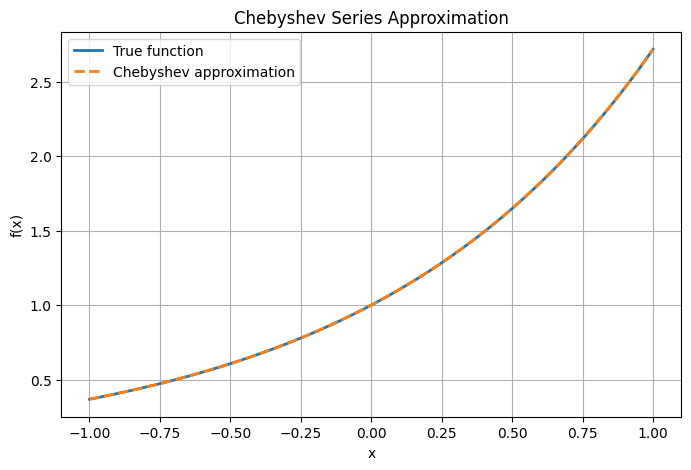

In [140]:

import numpy as np
from numpy.polynomial.chebyshev import chebpts2, chebfit, chebval, Chebyshev
import matplotlib.pyplot as plt
import torch

def inter_f(x):
    # return np.sin(math.pi*x)
    return np.exp(x)

def inter_prime_f(x):
    return np.exp(x)
    # return math.pi * np.cos(math.pi*x)

def inter_prime_prime_f(x):
    return np.exp(x)
    # return (-1) * math.pi**2 * np.sin(math.pi*x)


def get_cheb_coef(pvals):
    # print(pvals)
    v = np.concatenate([pvals, pvals[-2:0:-1]])  # mirror
    # print(v)
    V = np.fft.fft(v) 
    # print(V)
    a = V[:N].astype(np.complex128)  # keep complex type until we take real part
    # print(a)
    
    a[0] /= (2.0 * (N-1))   # this is the "first" after reversing
    a[-1] /= (2.0 * (N-1))  # this is the "last" after reversing
    if N > 1:
        a[1:-1] /= (N-1)

    # print(a.imag)
    a = a.real
    return a

# Chebyshev–Lobatto nodes (extrema), descending order
N = 100

x = chebpts2(N)[::-1]
# print('cheb nodes')
# print(x)
f = inter_f(x)

# coef_cheb_fit = chebfit(x[::-1], f[::-1], deg=N-1)   
coef = get_cheb_coef(f)
x_new = np.linspace(-1, 1, 501)
f_cheb_inter = chebval(x_new, coef)

f_cheb_fit = chebval(x_new, coef_cheb_fit)


print(f_cheb_inter[-1])


plt.figure(figsize=(8,5))
plt.plot(x_new, inter_f(x_new), label=f'True function', linewidth=2)
plt.plot(x_new, f_cheb_inter, '--', label='Chebyshev approximation', linewidth=2)
# plt.plot(x_new, f_cheb_fit, '--', label='Cheb fit', linewidth=2)

# plt.scatter(x, f, color='red', label='Chebyshev nodes')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Chebyshev Series Approximation')
plt.grid(True)

# print(coef_cheb_fit)
# print(coef)
                    

In [84]:
x = chebpts2(N)[::-1]
x

array([ 1.00000000e+00,  7.07106781e-01,  6.12323400e-17, -7.07106781e-01,
       -1.00000000e+00])

In [67]:
coef_cheb_fit

array([ 2.66117361e-17,  5.69230686e-01,  3.31380482e-16, -6.66916674e-01,
        1.89360275e-16,  1.04282464e-01, -3.78720551e-16, -6.84648379e-03,
       -3.78720551e-16,  2.50006885e-04])

In [69]:
len(coef)

18

2.7182818284615373


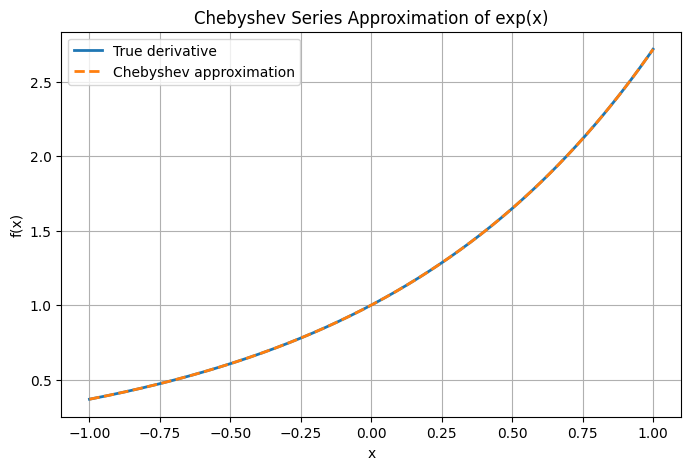

In [141]:
def cheb_derivative_coeffs(a):
    """
    Compute Chebyshev coefficients of the derivative p'(x) when
    p(x) = sum_{k=0}^N a[k] * T_k(x).

    Implements recurrence (Battles & Trefethen 2004, eq. (6.3)):
        b_{k-1} = b_{k+1} + 2*k*a[k],   for k = N, ..., 2
        b_0 = b_2/2 + a_1
        b_N = b_{N+1} = 0
    Returns:
        b[0..N-1]  (since derivative has degree N-1)
    """

    # a has length N+1
    N = len(a) - 1

    # Allocate b[0..N], but only b[0..N-1] are used finally
    b = np.zeros_like(a)

    # Apply recurrence from k = N down to k = 2
    # b[k+1] is valid only if k+1 <= N, otherwise treat as 0
    for k in range(N, 1, -1):
        if k + 1 <= N:
            b[k-1] = b[k+1] + 2.0 * k * a[k]
        else:
            b[k-1] = 2.0 * k * a[k]

    # Special formula for k = 0:
    # b0 = b2/2 + a1
    b[0] = b[2] / 2.0 + a[1]

    # Return only b[0..N-1]
    return b[:N]



derivative_coef = cheb_derivative_coeffs(coef)

fprime_approx = chebval(x_new, derivative_coef)

print(fprime_approx[-1])


plt.figure(figsize=(8,5))
plt.plot(x_new, inter_prime_f(x_new), label=f'True derivative', linewidth=2)
plt.plot(x_new, fprime_approx, '--', label='Chebyshev approximation', linewidth=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Chebyshev Series Approximation of exp(x)')
plt.grid(True)

In [126]:
error = np.linalg.norm(inter_prime_f(x_new) - fprime_approx)
error


2.577908230167039e-12

In [129]:
inter_prime_f(1)

2.718281828459045

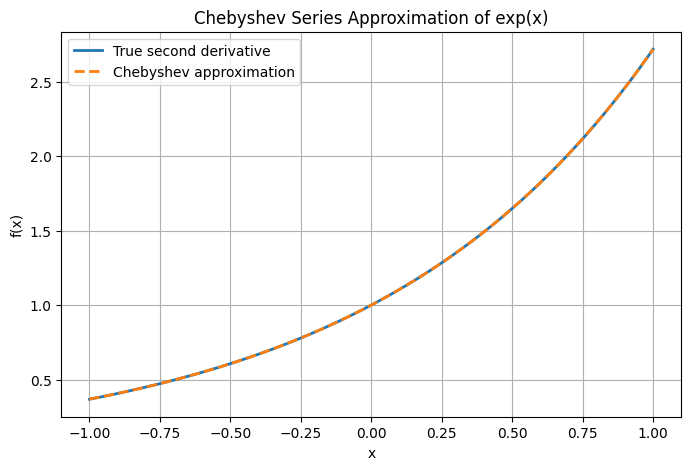

In [130]:
second_derivative_coef = cheb_derivative_coeffs(derivative_coef)

fprime_prime_approx = chebval(x_new, second_derivative_coef)

plt.figure(figsize=(8,5))
plt.plot(x_new, inter_prime_prime_f(x_new), label=f'True second derivative', linewidth=2)
plt.plot(x_new, fprime_prime_approx, '--', label='Chebyshev approximation', linewidth=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Chebyshev Series Approximation of exp(x)')
plt.grid(True)

In [135]:
error = np.linalg.norm(inter_prime_prime_f(x_new) - fprime_prime_approx)
error

5.592448354678233e-09

In [134]:
fprime_prime_approx[-1]

2.718281834026129

In [138]:
inter_f(0)

1.0